### 1. 初步探索   
#### 通过比对，发现在第二个地址中存放着关于疫情的数据，因此先对这个地址进行爬虫。

In [ ]:
import requests
import pandas as pd
import time 
pd.set_option('max_rows',500)

In [ ]:
# 设置请求头，伪装成游览器
headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36'
}

In [ ]:
url = 'https://c.m.163.com/ug/api/wuhan/app/data/list-total'   # 定义要访问的地址
r = requests.get(url, headers=headers)  # 使用requests发起请求

In [ ]:
print(r.status_code)  # 查看请求状态
print(type(r.text))
print(len(r.text))

In [ ]:
import json
data_json = json.loads(r.text)
data_json.keys()

In [ ]:
data = data_json['data'] # 取出json中的数据
data.keys()

### 2. 时事数据爬取
#### 2.1 全国各省实时的实时数据爬取


In [ ]:
data_province = data['areaTree'][2]['children']  #取出中国各省的实时数据
type(data_province)

In [ ]:
data_province[0].keys() #查看各个省键名称

键名称|数据内容
---|---:
today|各省当日数据|
total|各省当日累计数据
extData|无任何数据
name|各省名称
id|各省行政编号
lastUpdateTime|更新时间
children|各省下一级数据

In [ ]:
for i in range(len(data_province)):#遍历查看各省名称、更新时间
    print(data_province[i]['name'],data_province[i]['lastUpdateTime'])
    if i == 5:
        break 

In [ ]:
pd.DataFrame(data_province).head() #直接生成数据效果并不理想

In [ ]:
# 获取id、lastUpdateTime、name
info = pd.DataFrame(data_province)[['id','lastUpdateTime','name']]
info.head()

In [ ]:
# 获取today中的数据
today_data = pd.DataFrame([province['today'] for province in data_province])
today_data.head()

In [ ]:
['today_'+i for i in today_data.columns]

In [ ]:
today_data.columns = ['today_'+i for i in today_data.columns] # 由于today中键名和total键名相同，因此需要修改列名称

In [ ]:
today_data.head()

In [ ]:
# 获取total中的数据
total_data = pd.DataFrame([province['total'] for province in data_province ])
total_data.columns = ['total_'+i for i in total_data.columns]
total_data.head()

In [ ]:
pd.concat([info,total_data,today_data],axis=1).head() # 将三个数据合并

In [ ]:
# 将提取数据的方法封装为函数
def get_data(data,info_list):
    info = pd.DataFrame(data)[info_list] # 主要信息
    
    today_data = pd.DataFrame([i['today'] for i in data ]) # 生成today的数据
    today_data.columns = ['today_'+i for i in today_data.columns] # 修改列名
    
    total_data = pd.DataFrame([i['total'] for i in data ]) # 生成total的数据
    total_data.columns = ['total_'+i for i in total_data.columns] # 修改列名
    
    return pd.concat([info,total_data,today_data],axis=1) # info、today和total横向合并最终得到汇总的数据

In [ ]:
today_province = get_data(data_province,['id','lastUpdateTime','name'])
today_province.head()

In [ ]:
def save_data(data,name): # 定义保存数据方法
    file_name = name+'_'+time.strftime('%Y_%m_%d',time.localtime(time.time()))+'.csv'
    data.to_csv(file_name,index=None,encoding='utf_8_sig')
    print(file_name+' 保存成功！')
time.strftime('%Y_%m_%d',time.localtime(time.time()))
save_data(today_province,'today_province')

### 2.2 世界各国实时数据爬取
#### 之前已经了解到在json数据data中的areaTree是列表格式，每个元素都是一个国家的实时数据，每个元素的children是各国家省份的数据，现在我们提取世界各国实时数据。

In [ ]:
areaTree = data['areaTree'] # 取出areaTree

In [ ]:
areaTree[0] # 查看第一个国家的数据

In [ ]:
areaTree[0].keys()

In [ ]:
for i in range(len(areaTree)):  # 查看各国家名称和更新时间
    print(areaTree[i]['name'],areaTree[i]['lastUpdateTime'])
    if i == 5:
        break

In [ ]:
today_world = get_data(areaTree,['id','lastUpdateTime','name'])
today_world.head()

In [ ]:
save_data(today_world,'today_world')

### 3.历史数据爬取
#### 3.1 全国历史数据爬取
#### 在数据data中，总共有四个键，其中chinaDayList存放着中国的历史数据，我们将其取出。

In [ ]:
data.keys()

In [ ]:
chinaDayList = data['chinaDayList'] # 取出chinaDayList

In [ ]:
chinaDayList[0]

In [ ]:
alltime_China = get_data(chinaDayList,['date','lastUpdateTime'])
alltime_China.head()

In [ ]:
save_data(alltime_China,'alltime_China')

### 3.2 全国各省历史数据爬取
#### 找到第二个数据地址https://c.m.163.com/ug/api/wuhan/app/data/list-by-area-code?areaCode=420000 ，在页面对比发现是湖北省的历史数据。

In [ ]:
url = 'https://c.m.163.com/ug/api/wuhan/app/data/list-by-area-code?areaCode=420000' # 定义数据地址
r = requests.get(url, headers=headers) # 进行请求
data_json = json.loads(r.text) # 获取json数据

In [ ]:
data_json.keys()

In [ ]:
data_json['data']['list'][0]

In [ ]:
data_test = get_data(data_json['data']['list'],['date'])
data_test['name'] = '湖北省'
data_test.head()

In [ ]:
today_province[['id','name']].head()

在百度上查找全国各省的行政代码，结果发现和数据today_province中的id这一列一致，因此id这一列就是各省的行政代码。

因此为了得到每个省的历史数据，我们只需要将各省的行政代码作为参数传入这个地址即可，如下所示：
https://c.m.163.com/ug/api/wuhan/app/data/list-by-area-code?areaCode=各省行政代码
例如广东省历史数据的地址为：https://c.m.163.com/ug/api/wuhan/app/data/list-by-area-code?areaCode=440000
湖南省历史数据的地址为：https://c.m.163.com/ug/api/wuhan/app/data/list-by-area-code?areaCode=430000

但是数据中并没有显示省的名称，因此需要写入每个省的名称。

为了便于写入各省的名称，需要生成一个各省行政代码和省名称对应的字典。


In [ ]:
province_dict = {num:name for num,name in zip(today_province['id'],today_province['name'])}

In [ ]:
# 查看前五个内容
count = 0
for i in province_dict:
    print(i,province_dict[i])
    count += 1
    if count == 5:
        break

每一个省的列名是相同的，因此多个省的数据合并起来就可以存入一个数据中

In [ ]:
start = time.time()
for province_id in province_dict: # 遍历各省编号
    
    try:
        # 按照省编号访问每个省的数据地址，并获取json数据
        url = 'https://c.m.163.com/ug/api/wuhan/app/data/list-by-area-code?areaCode='+province_id
        r = requests.get(url, headers=headers)
        data_json = json.loads(r.text)
        
        # 提取各省数据，然后写入各省名称
        province_data = get_data(data_json['data']['list'],['date'])
        province_data['name'] = province_dict[province_id]
        
        # 合并数据
        if province_id == '420000':
            alltime_province = province_data
        else:
            alltime_province = pd.concat([alltime_province,province_data])
            
        print('-'*20,province_dict[province_id],'成功',
              province_data.shape,alltime_province.shape,
              ',累计耗时:',round(time.time()-start),'-'*20)
        
        # 设置延迟等待
        time.sleep(20)
        
    except:
        print('-'*20,province_dict[province_id],'wrong','-'*20)

In [ ]:
alltime_province.info()

In [ ]:
save_data(alltime_province,'alltime_province')

### 3.3 世界各国历史数据爬取
#### 接着找到下一个数据地址，对比后发现是意大利数据，首先尝试爬取意大利的历史数据，其他国家的数据可以用同样的方法爬取。

In [ ]:
import json

In [ ]:
url_italy = 'https://c.m.163.com/ug/api/wuhan/app/data/list-by-area-code?areaCode=15'  # 意大利的数据地址
r = requests.get(url_italy, headers=headers) # 进行访问
italy_json = json.loads(r.text) # 导出json数据

In [ ]:
italy_json.keys()

In [ ]:
italy_json['data'].keys()

In [ ]:
italy_json['data']['list'][0] # 查看数据内容

In [ ]:
data_italy = get_data(italy_json['data']['list'],['date']) # 生成数据
data_italy['name'] = '意大利' # 写入国家名称
data_italy.head()

In [ ]:
today_world[['id','name']].head()

In [ ]:
country_dict = {key:value for key,value in zip(today_world['id'], today_world['name'])}

In [ ]:
# 查看前五个内容
count = 0
for i in country_dict:
    print(i,country_dict[i])
    count += 1
    if count == 5:
        break

通过每个国家的编号访问每个国家历史数据的地址，然后获取每一个国家的历史数据。

In [ ]:
start = time.time()
for country_id in country_dict: # 遍历每个国家的编号
    
    try:
        # 按照编号访问每个国家的数据地址，并获取json数据
        url = 'https://c.m.163.com/ug/api/wuhan/app/data/list-by-area-code?areaCode='+country_id
        r = requests.get(url, headers=headers)
        json_data = json.loads(r.text)
        
        # 生成每个国家的数据
        country_data = get_data(json_data['data']['list'],['date'])
        country_data['name'] = country_dict[country_id]

        # 数据叠加
        if country_id == '9577772':
            alltime_world = country_data
        else:
            alltime_world = pd.concat([alltime_world,country_data])
            
        print('-'*20,country_dict[country_id],'成功',country_data.shape,alltime_world.shape,
              ',累计耗时:',round(time.time()-start),'-'*20)
        
        time.sleep(25)

    except:
        print('-'*20,country_dict[country_id],'wrong','-'*20)

In [ ]:
alltime_world.shape

In [ ]:
save_data(alltime_world,'alltime_world')

In [ ]:
# 更多相关学习,可阅读pymongo官网 :https://api.mongodb.com/python/3.4.0/
# 其他详细操作,如索引等，可阅读mongo官网: https://docs.mongodb.com/manual/reference/operator/query/
# 1.导入pymongo
import pymongo

In [ ]:
# 2.测试mongo 连接
client=pymongo.MongoClient(host='localhost',port=27017)  #本机上单节点mongo
# client=pymongo.MongoClient('mongodb://192.168.28.201:27017')  虚拟机上单节点mongo
#client=pymongo.MongoClient('mongodb://192.168.28.201:23000')  # 集群
client


In [ ]:
# 3.指定数据库
db=client['COVID-19']# database
db
# 4.指定集合  
collection=db.alltime_China_2020_12_05
collection


### 数据处理

In [ ]:
import pandas as pd

# 读取数据
today_world = pd.read_csv("today_world_2020_12_05.csv")

In [ ]:
# 查看世界各国实时数据 
today_world.head()

In [ ]:
name_dict = {'date':'日期','name':'名称','id':'编号','lastUpdateTime':'更新时间',
             'today_confirm':'当日新增确诊','today_suspect':'当日新增疑似',
             'today_heal':'当日新增治愈','today_dead':'当日新增死亡',
             'today_severe':'当日新增重症','today_storeConfirm':'当日现存确诊',
             'total_confirm':'累计确诊','total_suspect':'累计疑似',
             'total_heal':'累计治愈','total_dead':'累计死亡','total_severe':'累计重症'}

# 更改列名
today_world.rename(columns=name_dict,inplace=True)    # inplace参数判断是否在原数据上进行修改

today_world.head()

In [ ]:
# 查看数据基本信息
today_world.info()

In [ ]:
# 计算缺失值比例
today_world_nan = today_world.isnull().sum()/len(today_world)

# 转变为百分数
today_world_nan.apply(lambda x: format(x, '.1%')) 

In [ ]:
# 缺失值处理
today_world['当日现存确诊'] = today_world['累计确诊']-today_world['累计治愈']-today_world['累计死亡']

In [ ]:
# 将国家名称设为索引
today_world.set_index('名称',inplace=True)

today_world.head(3)

In [ ]:
today_world.loc['中国']    #可以通过传入列表获取多个国家的数据

In [1]:
# 查看当前累计确诊人数前十国家
world_top10 = today_world.sort_values(['累计确诊'],ascending=False)[:10]

world_top10 = world_top10[['累计确诊','累计死亡']]

NameError: name 'today_world' is not defined

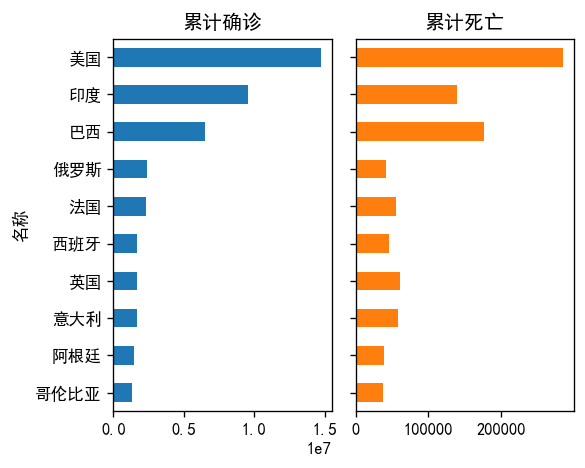

In [67]:
# 导入matplotlib
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['SimHei']    #正常显示中文
plt.rcParams['figure.dpi'] = 120      #设置所有图片的清晰度
# 绘制条形图
world_top10.sort_values('累计确诊').plot.barh(subplots=True,layout=(1,3),sharex=False,
                                             figsize=(7,4),legend=False,sharey=True)

plt.tight_layout()   #调整子图间距
plt.show()